In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

import os
import sys
import glob
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from IPython.display import display
from pathlib import Path
from smart_open import open
from tqdm.auto import tqdm
tqdm.pandas()

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn import utils
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import re

import spacy
from tokenizer import MergedTokenizer

In [2]:
nlp = spacy.load('en_core_web_lg')

In [4]:
data = []
for cat in tqdm(os.listdir('bbc')):
    for fname in glob.glob('bbc/' + cat + '/*.txt'):
        file = Path(fname)
        iid = cat + '-' + file.name.split('.')[0]
        try:
            txt = file.read_text(encoding='utf', errors='ignore')
        except:
            print(iid)
        data.append([iid, txt, cat])
        
df = pd.DataFrame(data, columns=['ArticleId', 'Text', 'Category']); df

,ArticleId,Text,Category
0,business-001,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,business-002,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,business-003,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,business-004,High fuel prices hit BA's profits\n\nBritish A...,business
4,business-005,Pernod takeover talk lifts Domecq\n\nShares in...,business
5,business-006,Japan narrowly escapes recession\n\nJapan's ec...,business
6,business-007,Jobs growth still slow in the US\n\nThe US cre...,business
7,business-008,"India calls for fair trade rules\n\nIndia, whi...",business
8,business-009,Ethiopia's crop production up 24%\n\nEthiopia ...,business
9,business-010,Court rejects $280bn tobacco case\n\nA US gove...,business


In [5]:
df['category_id'] = df['Category'].factorize()[0];df
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id'); category_id_df
category_to_id = dict(category_id_df.values); category_to_id

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [6]:
labels = df.category_id

In [66]:
merged_tokenizer = MergedTokenizer(nlp, merge_chunks=False, merge_ner=True)
tagged = []

for row in tqdm(list(df.itertuples())[:]):
    tokens = merged_tokenizer.lemmatized(row.Text)
    tagged.append(TaggedDocument(words=tokens, tags=[row.Index]))

In [91]:
tagged[100]

TaggedDocument(words=['australia', 'rate', 'four_year', 'high', 'australia', 'raise', 'benchmark', 'interest', 'rate', 'high', 'level', 'four_years', 'sign', 'slowdown', 'country', 'economy', 'the_reserve_bank_of_australia', 'lift', 'interest', 'rate', '0.25%_to_5.5%', 'upwards', 'more_than_a_year', 'shortly', 'bank', 'decision', 'new', 'figure', 'show', 'fall', 'economic', 'growth', 'the_last_quarter', 'bank', 'say', 'act', 'curb', 'inflation', 'criticise', 'analyst', 'rate', 'hike', 'december_2003', 'flag', 'advance', 'opposition', 'party', 'analyst', 'say', 'ill', 'time', 'give', 'datum', 'show', 'australian', 'economy', 'grow', 'just_0.1%', '1.5%', 'annual', 'basis', 'figure', 'represent', 'decline', '0.2%', 'growth', 'gdp', 'see', 'market', 'expectation', 'consumer', 'spending', 'remain', 'strong', 'bank', 'concerned', 'grow', 'inflationary', 'pressure', 'recent_months', 'increasingly', 'clear', 'remain', 'spare', 'capacity', 'labour', 'good', 'market', 'limited', 'say', 'ian_macf

In [149]:
# d2v = Doc2Vec(dm=0, vector_size=300, negative=3, min_count=3, epochs=30, workers=4)#, alpha=0.065, min_alpha=0.065)
# d2v.build_vocab(tagged)
# d2v.train(tagged, total_examples=d2v.corpus_count, epochs=d2v.epochs)

# for epoch in range(30):
#     d2v.train(utils.shuffle(tagged), total_examples=d2v.corpus_count, epochs=1)
#     d2v.alpha -= 0.002
#     d2v.min_alpha = d2v.alpha

In [67]:
d2v = Doc2Vec(documents=tagged, vector_size=200, window=3, min_count=2, epochs=30, workers=4)
d2v.init_sims(replace=False)

In [88]:
simdocs = d2v.docvecs.most_similar(positive=[d2v.wv['sport']], topn=50); simdocs;

In [89]:
df.iloc[list(dict(simdocs).keys())]

,ArticleId,Text,Category,category_id
703,entertainment-194,Ethnic producers 'face barriers'\n\nMinority e...,entertainment,1
801,entertainment-292,Tough schedule delays Elliot show\n\nPreview p...,entertainment,1
790,entertainment-281,Church urges Nelly show boycott\n\nChurch mini...,entertainment,1
531,entertainment-022,Fears raised over ballet future\n\nFewer child...,entertainment,1
530,entertainment-021,Obituary: Dame Alicia Markova\n\nDame Alicia M...,entertainment,1
1847,tech-024,Game firm holds 'cast' auditions\n\nVideo game...,tech,4
822,entertainment-313,BBC to pour £9m into new comedy\n\nThe BBC is ...,entertainment,1
1628,sport-316,Wales stars need a rest - Ruddock\n\nWales coa...,sport,3
1067,politics-172,Faith schools citizenship warning\n\nSchools m...,politics,2
1355,sport-043,Collins named UK Athletics chief\n\nUK Athleti...,sport,3


In [58]:
d2v.docvecs.vectors_docs[0]

array([-0.96274894,  0.21830694, -2.8146713 ,  0.25543624,  2.1382875 ,
       -0.38558877, -0.16014473, -1.2894208 ,  1.098361  , -2.661807  ,
        1.3737706 , -0.5156266 , -0.7113162 ,  0.8731447 , -0.05942068,
        2.3841114 , -1.9719567 ,  1.995091  ,  1.6666452 ,  0.09647573,
       -1.7922007 ,  3.0909772 , -1.0845908 , -0.08485638,  0.11778738,
       -2.2386677 , -1.7596304 ,  1.9557544 ,  0.71730906, -2.6404777 ,
        0.8555948 , -1.8999596 , -1.2548406 , -1.8754094 ,  1.4322493 ,
       -1.4454478 , -0.89896095, -2.347214  ,  0.62329775,  1.8544041 ,
        1.0032122 ,  0.8321654 , -1.1960022 ,  1.2125747 , -1.9447973 ,
       -3.0583487 ,  1.3437313 ,  0.9680358 , -2.7247968 , -0.48176444,
       -2.7652926 ,  0.38871607,  0.8760985 ,  0.73147655, -0.6598295 ,
       -1.0743332 ,  0.5112602 ,  1.8295892 ,  2.2528389 , -1.7344455 ,
        0.29333404, -0.51174766, -0.568351  ,  2.7447658 ,  2.4047525 ,
        2.0720687 , -1.3685175 ,  0.7328436 ,  2.2243435 , -1.10

In [203]:
d2v.docvecs.vectors_docs.shape

(2225, 50)

In [204]:
# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
features = scaler.fit_transform(d2v.docvecs.vectors_docs)
# features = d2v.docvecs.vectors_docs

In [205]:
SAMPLE_SIZE = int(len(features)*0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]); projected_features.shape

(667, 2)

In [206]:
category_id_test = 0
projected_features[labels[indices]==category_id_test]

array([[  5.3454056 , -21.65213   ],
       [ 18.151718  , -22.512321  ],
       [  8.088705  , -24.753115  ],
       [ -5.1791253 , -22.196232  ],
       [-16.293106  ,  15.857705  ],
       [  6.3082256 , -30.267061  ],
       [ -8.133955  , -24.71745   ],
       [ 11.714009  , -16.244839  ],
       [ 17.884617  , -15.124232  ],
       [  2.8602757 , -27.170015  ],
       [ 11.707723  , -14.339994  ],
       [  6.76567   , -27.566721  ],
       [  3.4581537 , -29.397003  ],
       [ -6.85189   , -26.489258  ],
       [  3.0838056 , -25.544258  ],
       [ -0.6019139 , -14.16897   ],
       [  1.7278932 , -19.835178  ],
       [ -9.365687  , -11.496688  ],
       [  8.987416  , -16.122293  ],
       [ 14.779171  , -13.787662  ],
       [ 11.004247  , -23.799778  ],
       [ 10.707654  , -11.791852  ],
       [ 11.3802395 , -12.826663  ],
       [ 12.272584  , -12.349058  ],
       [ -6.209106  , -27.871504  ],
       [ 12.514404  , -12.287975  ],
       [  7.544851  , -28.784071  ],
 

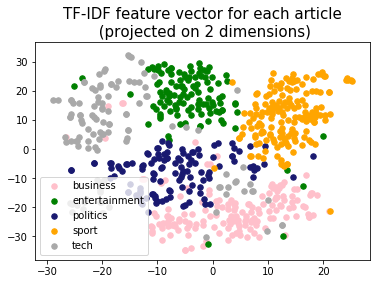

In [207]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

for category, category_id in sorted(category_to_id.items()):
    points = projected_features[labels[indices]==category_id]
    plt.scatter(points[:,0], points[:,1], s=30, c=colors[category_id], label=category)
    
plt.title('TF-IDF feature vector for each article\n (projected on 2 dimensions)', fontdict=dict(fontsize=15))
plt.legend();

In [208]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0), 
    #MultinomialNB(), 
    LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto', max_iter=500), 
    SGDClassifier(random_state=0, max_iter=200, tol=1e-3),  
    SVC(kernel='rbf', C=5, gamma='auto')
]

In [216]:
CV = 5
shufflesplit = ShuffleSplit(n_splits=CV, test_size=0.2, random_state=0)
entries = []

for model in tqdm(models):
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=shufflesplit)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

In [217]:
cv_df = pd.DataFrame(entries, index=range(CV*len(models)), columns=['model_name', 'fold_idx', 'accuracy']); cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.808989
1,RandomForestClassifier,1,0.820225
2,RandomForestClassifier,2,0.804494
3,RandomForestClassifier,3,0.784270
4,RandomForestClassifier,4,0.782022
5,LogisticRegression,0,0.905618
6,LogisticRegression,1,0.923596
7,LogisticRegression,2,0.912360
8,LogisticRegression,3,0.896629
9,LogisticRegression,4,0.914607


In [155]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.969438
RandomForestClassifier    0.928090
SGDClassifier             0.960899
Name: accuracy, dtype: float64

In [218]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.910562
RandomForestClassifier    0.800000
SGDClassifier             0.891685
SVC                       0.944719
Name: accuracy, dtype: float64